In [ ]:
#Sentence-transformers Roberta Inference v2 


## fine tuning architecture :  reference

### Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks


https://arxiv.org/pdf/1908.10084.pdf

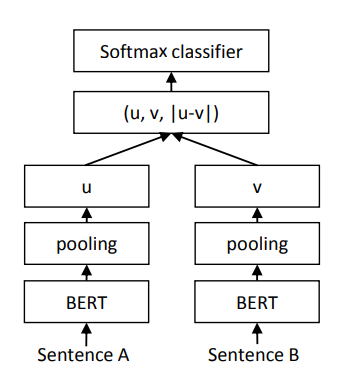 

In [ ]:
import gc
import os
import sys
import time
import pickle
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.simplefilter('ignore')

In [ ]:
def fetchEssay(essay_id: str):
    """
    Read the text file of the specific essay_id
    """
    essay_path = os.path.join('../input/feedback-prize-effectiveness/test/', essay_id + '.txt')
    essay_text = open(essay_path, 'r').read()
    return essay_text


In [ ]:
class callback:
    def __init__(self):
        self.loss = list()
        self.model = list()
    
    def put(self, model, loss):
        self.loss.append(loss)
        self.model.append(model)

    def get_model(self):
        ind = np.argmin(self.loss)
        return self.model[ind]

    

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)



class FeedBackModel(nn.Module):
    def __init__(self, model_path):
        super(FeedBackModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_path)
        #self.lstm = nn.LSTM(768, 256, bidirectional=True, batch_first=True)
        self.weights = torch.rand(2, 768*3)
        self.linear = nn.Linear(768*3, 768)
        self.linear2 = nn.Linear(768, 3)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, ids, mask):
        avg_pool_seqs = torch.zeros((len(ids), 768*3)).cuda()
        for i in range(len(ids)):
          out = self.model(ids[i], mask[i])
          pool = mean_pooling(out, mask[i]).cuda()
          u = pool[0]
          v = pool[1]
          uv_abs = torch.abs(u-v)
          avg_pool_seqs[i] = torch.cat([u, v, uv_abs])

        x = self.linear(self.drop(avg_pool_seqs))
        x = self.linear2(x)
        return x 

class FeedBackDataset(Dataset):
    def __init__(self, data, tokenizer, is_test=False):
        self.data = data
        self.is_test = is_test
        self.tokenizer = tokenizer
        
        
    def __getitem__(self, idx):

        res = torch.ones(2, MAX_LEN, dtype=torch.long)
        res_mask = torch.zeros(2, MAX_LEN, dtype=torch.long)

        inputs = self.tokenizer.encode_plus(
            self.data['discourse_type'].values[idx].lower().lstrip().rstrip() + ' ' + self.data['discourse_text'].values[idx].lower().lstrip().rstrip(),
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN
        )['input_ids'] 

        inputs = inputs[:MAX_LEN]          
        mask = [1]*len(inputs) + [0] * (MAX_LEN - len(inputs)) 
        mask = torch.tensor(mask, dtype=torch.long)
        
        if len(inputs) != MAX_LEN:
            inputs = inputs + [self.tokenizer.pad_token_id] * (MAX_LEN - len(inputs)) 
        ids = torch.tensor(inputs, dtype=torch.long) 

        res[0] = ids
        res_mask[0] = mask
        
        
        essay_sent_encode = self.tokenizer.encode_plus(
            self.data['essay'].values[idx].lower().lstrip().rstrip(),
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN
        )['input_ids']

        essay_sent_mask = [1]*len(essay_sent_encode) + [0] * (MAX_LEN - len(essay_sent_encode)) 
        essay_sent_mask = torch.tensor(essay_sent_mask, dtype=torch.long)

        if len(essay_sent_encode) != MAX_LEN:
            essay_sent_encode = essay_sent_encode + [self.tokenizer.pad_token_id] * (MAX_LEN - len(essay_sent_encode)) 

        res[1] = torch.tensor(essay_sent_encode, dtype=torch.long)
        res_mask[1] = essay_sent_mask

        if not self.is_test:
            target_value = self.data[y_cols].values[idx]


        
        if self.is_test:
            return {
                'ids': res,
                'mask': res_mask,
            }
        
        else:
            targets = torch.FloatTensor(target_value)
            return {
                'ids': res,
                'mask': res_mask,
                'targets': targets
            }
                

    def __len__(self):
        return len(self.data)

In [ ]:
test_df = pd.read_csv("../input/feedback-prize-effectiveness/test.csv")
test_df['essay'] = test_df['essay_id'].apply(fetchEssay)

In [ ]:
model_path = '../input/nlirobertabase/nli-roberta-basev2'
y_cols = ['discourse_effectiveness']
tokenizer = AutoTokenizer.from_pretrained(model_path)


In [ ]:
NFOLDS = 5
BATCH_SIZE = 16
MAX_LEN = 512
test_loader = torch.utils.data.DataLoader(FeedBackDataset(test_df, tokenizer, True), batch_size=BATCH_SIZE, shuffle=False)
model_list = pickle.load(open("../input/feedback-sentence-roberta/sentence-roberta_modellist_v2.pkl", "rb"))
test_pred = np.zeros((len(test_df), 3))

In [ ]:
for idx in range(NFOLDS):
    print(f'start to inference fold : {idx}')
    net = model_list[idx]
    net.eval()
    net.cuda()
    result = list()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            input_ids = data['ids'].cuda()
            input_masks = data['mask'].cuda()
            pred = F.softmax(net(input_ids,input_masks))
            result.extend(pred.cpu().detach().numpy())
    test_pred += np.array(result)/NFOLDS

In [ ]:
submission_df = pd.read_csv('../input/feedback-prize-effectiveness/sample_submission.csv')
submission_df['Ineffective'] = test_pred[:,0]
submission_df['Adequate'] = test_pred[:,1]
submission_df['Effective'] = test_pred[:,2]
submission_df

In [ ]:
submission_df.to_csv('submission.csv',index=False)
